# Methylation and Deamination Estimators Simulation : Liran vs. Us

Author: lee.carlin@mail.huji.ac.il  
Date: 2020-05-24 
Last edited: 2020-05-26 

* Revising the generative model according to Benny's suggestions: building the model without the `i` index and ignoring pi_zero. 
* Simulating again according to the model above, with more structured pi vectored (as discussed in last week's meeting. 
* Try to calculate pi in my simulations from the real data we have (last iteration where we showed the trend of deamination along the reads)  
* m_i values coming closer to the real distribution ( e.g. a mixture with a component at 0.1 and one at 0.7). 

TODO:
* Try to isolate the bias-variance into :
    Choose 10 different m_i, for each generate 8 different pi_i (vectors), for each simulate 100 t_i. 
    You can get the estimator sd given pi_i and m_i. Compare to my likelihood sd (should be the same). 
    you can also get the differences between the means (this is because pi_i is different). 
    In addition: compare the situation between same m_i to varied m_i per i. 
* Maybe we should also do some regularization (empirical base on dist of m_i). (later)

HighLevel:
* IF the variance of pi is small enough, the old model is good enough. 
* However, if not, the conditional is better. 
* So- can we find the threshold / set of conditions to choose one over the other? In terms of standard deviation/ other moments. 

* 

In [1]:
# libraries:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, newton
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy.optimize import fsolve, newton
import scipy.stats as stats  
import time
import statistics
import seaborn as sns
import random

# Second Order Condition:
def SOC_binom(t,pi, m, n):   
    return -(((n-t)*(pi**2))/(1-pi*m)**2).sum()

 
# Squaring a list:
def square(list):
    return map(lambda x: x ** 2, list)

def mult(list, constant):
    return map(lambda x: x * constant, list)

# MLE (no pi_zero):
def FOC(M,n,pi,t):    
    theta = pi*M
    A = (t/M).sum()
    oneMinusT = np.array([1]*n)-np.array(t)
    oneMinusTheta = np.array([1]*n)-theta
    B = ((oneMinusT*pi)/(oneMinusTheta)).sum()
    return (A-B)

def SOC(M,n,pi,t):    
    A = (t/M**2).sum()
    oneMinusT = np.array([1]*n)-np.array(t)
    oneMinusTheta = np.array([1]*n)-pi*M
    B = ((oneMinusT*(pi**2))/(oneMinusTheta)**2).sum()
    return (-A-B)


In [ ]:
def make_scatters(df):
    fig,axs = plt.subplots(2, 2, sharey=True,sharex=True,figsize = (22,14))
    axs[0,0].scatter(df.true_m,df.liran_pi, color='yellow', alpha = 0.4, label = 'Liran Pi model', s=15)   
    axs[0,0].scatter(df.true_m,df.liran, color='black', alpha = 0.4, label = 'Liran model', s=15 )
    axs[0,0].plot( np.linspace(*ax.get_xlim()), np.linspace(*ax.get_xlim()), label = '45 degree line')
    axs[0,0].set_title('MLE Deviations from True m for Liran vs. Liran Pi Model', fontsize=12)
    axs[0,1].scatter(df.true_m,df.liran, color='black', alpha = 0.4, label = 'Liran model', s=15 )
    axs[0,1].scatter(df.true_m,df.our, color='blue', alpha = 0.4, label = 'Our model', s=15)    
    axs[0,1].plot( np.linspace(*ax.get_xlim()), np.linspace(*ax.get_xlim()), label = '45 degree line')
    axs[0,1].set_title('MLE Deviations from True m for Liran vs. Our Model', fontsize=12)
    axs[1,0].scatter(df.true_m,df.liran, color='black', alpha = 0.4, label = 'Liran model', s=15 )
    axs[1,0].scatter(df.true_m,df.glm, color='green', alpha = 0.4, label = 'GLM model', s=15)    
    axs[1,0].plot( np.linspace(*ax.get_xlim()), np.linspace(*ax.get_xlim()), label = '45 degree line')
    axs[1,0].set_title('MLE Deviations from True m for Liran vs. GLM Model', fontsize=12)
    axs[1,1].scatter(df.true_m,df.our, color='blue', alpha = 0.4, label = 'Our model', s=15 )
    axs[1,1].scatter(df.true_m,df.glm, color='green', alpha = 0.4, label = 'GLM model', s=15)    
    axs[1,1].plot( np.linspace(*ax.get_xlim()), np.linspace(*ax.get_xlim()), label = '45 degree line')
    axs[1,1].set_title('MLE Deviations from True m for Our vs. GLM Model', fontsize=12)
    axs[0,0].legend(loc='upper left',frameon = False,fontsize= 11)
    axs[0,1].legend(loc='upper left',frameon = False,fontsize= 11)
    axs[1,0].legend(loc='upper left',frameon = False,fontsize= 11)
    axs[1,1].legend(loc='upper left',frameon = False,fontsize= 11)
    axs[0,0].set_xlabel('$m_i$', fontsize=14)
    axs[0,0].set_ylabel('$MLE_i$', fontsize=14)

# Simulating Data:

Using a position depended Binomial model $t_{r} \sim Bern(\theta_{r})$   
for  $\theta$ such that  $\quad \theta_{r} =  m \times\pi _{r}$  
simulate a vector of $t_r$ for $r \in [1,2,\dots,c]$ and estimate $m$ using Liran's and our models:

In [2]:


###########################################
def sim(input_dict):
    sample_len = input_dict['sample_len'] 
    coverage_mean  = input_dict['coverage_mean'] 
    coverage_sd = input_dict['coverage_sd'] 
    m_sd = input_dict['m_sd'] 
    m_low = input_dict['m_low'] 
    m_high = input_dict['m_high'] 
    m_initial_guess = input_dict['m_initial_guess'] 
    pi_dist = input_dict['pi_dist']
    weights =input_dict['weights']
    limitBounds = input_dict['limitBounds']
    pi_calib_runs = input_dict['pi_calib_runs']
    # list objects for accounting:
    t_list = []
    liran_list = []
    liran_pi_list = []
    liran_sd_list = []
    our_list = []
    our_sd_list = []
    glm_list = []
    pi_list = []
    pi_mean_list = []
    m_list = []
    glm_list = []
    ###########################################

    # Simulating Data:
    rng = range(0,sample_len) 
    pi_calib = 0.1
    for i in range(pi_calib_runs):
        for i in rng:
            # Sampling m:
            m = random.sample([m_low,m_high],1)[0]
            m = np.random.normal(m,m_sd,1)[0]
            if m>=1:
                m  = 0.99999
            elif m <=0:
                m = 0.00001
            #Sampling coverage:
            coverage = int(np.random.normal(coverage_mean, coverage_sd))
            # Sampling pi:
            pi = np.array(random.choices(pi_dist,weights=weights,k=coverage))
            theta = pi*m # Defining theta
            # Limiting theta:
            theta[theta>1]=1
            theta[theta<0]=0
            # Sampling t_i from a binomial(theta):
            t = np.random.binomial(1,theta)

            # Estimating using Liran's:
            #pi_calib =  0.1597686029694
            solution_liran = t.sum()/(coverage*pi_calib) #MLE: m = t/(pi*n)
            solution_liran_pi = t.sum()/(coverage*np.array(pi_dist)*np.array(weights)).sum() #MLE: m = t/(pi*n)
            # Estimating m using our model: 
            solution_our = fsolve(func=FOC, x0=m_initial_guess,args=(coverage,pi,t))[0]
            # Estimating m using GLM model: 
            df = pd.DataFrame(list(zip(pi,t)),columns = ['pi','t'])
            try: 
                solution_glm = sm.formula.glm("t ~ 0 + pi",
                                              family=sm.families.Binomial(link=sm.families.links.identity), 
                                              data=df ).fit().params['pi']
            except:
                solution_glm=0
            
            # Bounding estimators:
            if limitBounds:
                solution_liran = 0 if solution_liran<0 else solution_liran
                solution_liran = 1 if solution_liran>1 else solution_liran
                solution_liran_pi = 0 if solution_liran_pi<0 else solution_liran_pi
                solution_liran_pi = 1 if solution_liran_pi>1 else solution_liran_pi
                solution_our = 0 if solution_our<0 else solution_our
                solution_our = 1 if solution_our>1 else solution_our
                solution_glm = 0 if solution_glm<0 else solution_glm
                solution_glm = 1 if solution_glm>1 else solution_glm
            
            # Appending estimators:
            liran_list.append(solution_liran)
            liran_sd_list.append(np.sqrt(1/(-SOC_binom(t,pi_calib, solution_liran, coverage))))
            liran_pi_list.append(solution_liran_pi)
            our_list.append(solution_our)
            our_sd_list.append(np.sqrt(1/(-SOC(solution_our,coverage,pi,t))))
            glm_list.append(solution_glm)            

            # Accounting:
            pi_list.append(pi)
            pi_mean_list.append(pi.mean())
            m_list.append(m)
            t_list.append(t)
            pi_calib = np.array(pi_mean_list).mean()

    output_df = pd.DataFrame(list(zip(m_list, pi_list ,t_list,liran_list,liran_pi_list,our_list,glm_list)), 
                   columns =['samp_m', 'samp_p','samp_t','liran_est','liran_pi_est','our_est','glm_est']) 
    #output_df.to_pickle('/Users/leecarlin/Dropbox (Personal)/School/deamination/simulation_MLE_35_coverage.pickle')
    
    print('The empirical mean of m    : {:,}'.format(np.array(m_list).mean()))
    print('The empirical mean of pi   : {:,}'.format(np.array(pi_mean_list).mean()))
    print('The empirical mean of theta: {:,}\n'.format(np.array(pi_mean_list).mean()*np.array(m_list).mean()))

    print('The mean of the Liran model estimation   : {:,}'.format(np.array(liran_list).mean()))
    print('The mean of the Liran pi model estimation: {:,}'.format(np.array(liran_pi_list).mean()))
    print('The mean of the Our model estimation     : {:,}'.format(np.array(our_list).mean()))
    print('The mean of the GLM model estimation     : {:,}\n'.format(np.array(glm_list).mean()))
    
    print('The std of the Liran model estimation: {:,}'.format(np.array(liran_list).std()))
    print('The std of the Liran pi model estimation: {:,}'.format(np.array(liran_pi_list).std()))
    print('The std of the Our model estimation  : {:,}'.format(np.array(our_list).std()))
    print('The std of the GLM model estimation  : {:,}\n'.format(np.array(glm_list).std()))
    
    print('The mean of the Liran model MLE STD: {:,}'.format(np.array(liran_sd_list).mean()))
    our_sd_list_rmna = np.array(our_sd_list)[~np.isnan(np.array(our_sd_list))]
    print('The mean of the Our model MLE STD  : {:,}\n'.format(np.array(our_sd_list_rmna).mean()))
    
    MSE_liran = np.sqrt(((np.array(liran_list)-np.array(m_list))**2).mean())
    MSE_our = np.sqrt(((np.array(our_list)-np.array(m_list))**2).mean())
    print('RMSE of Lirans Model        : {:,}'.format(MSE_liran))
    print('RMSE of Our Model           : {:,}'.format(MSE_our))
    print('RMSE DIfference (vs. Liran) : {:%}\n'.format((MSE_our-MSE_liran)/MSE_liran))
    
    GLM_MSE = np.sqrt(((np.array(glm_list)-np.array(m_list))**2).mean())
    print('RMSE of GLM Model           : {:,}'.format(GLM_MSE))
    print('RMSE DIfference (vs. Liran) : {:%}\n'.format((GLM_MSE-MSE_liran)/MSE_liran))
    
    output_est = pd.DataFrame(list(zip(m_list,liran_list,liran_pi_list,our_list,glm_list)),columns =['true_m','liran','liran_pi','our','glm'])
    
    output = {'t_list':t_list,
             'liran_list':liran_list,
             'liran_pi_list':liran_pi_list,
             'our_list':our_list,
             'glm_list':glm_list,
             'liran_sd_list':liran_sd_list,
             'our_sd_list':our_sd_list,
             'pi_list':pi_list,
             'pi_mean_list':pi_mean_list,
             'm_list':m_list,
             'output_est':output_est,
             'output_df':output_df}
    return(output)

In [15]:
import warnings
warnings.filterwarnings("ignore", message="")
# Parameters:
# General:
###########################################
input_dict = {'sample_len' : 1000, 
              'coverage_mean'  : 200,
              'coverage_sd' : 5,
              'm_sd' : 0.1, 
              'm_low' : 0.2, 
              'm_high' : 0.7, 
              'm_initial_guess' : 0.45,
              'limitBounds': True,
              'pi_calib_runs':1,
              #'pi_dist' : [0.8,0.6,0.4,0.02],
              'pi_dist' : [0.8,0.6,0.3,0.02],
              #'pi_dist' : list(mult([0.4,0.3,0.2,0.02],2)),
              'weights' : [3/50,3/50,4/50,40/50]
             }
output = sim(input_dict)

The empirical mean of m    : 0.4527674056760883
The empirical mean of pi   : 0.1240651334123121
The empirical mean of theta: 0.05617264858995033

The mean of the Liran model estimation   : 0.4573058350858449
The mean of the Liran pi model estimation: 0.45937223223486423
The mean of the Our model estimation     : 0.45566009163145177
The mean of the GLM model estimation     : 0.45828909796860845

The std of the Liran model estimation: 0.2916156955225476
The std of the Liran pi model estimation: 0.29260120453943766
The std of the Our model estimation  : 0.2883669001683408
The std of the GLM model estimation  : 0.28444215253515354

The mean of the Liran model MLE STD: 0.03802966102138242
The mean of the Our model MLE STD  : 0.10902832330463885

RMSE of Lirans Model        : 0.12682862181896248
RMSE of Our Model           : 0.1080107167833062
RMSE DIfference (vs. Liran) : -14.837270%

RMSE of GLM Model           : 0.10603114394054794
RMSE DIfference (vs. Liran) : -16.398095%



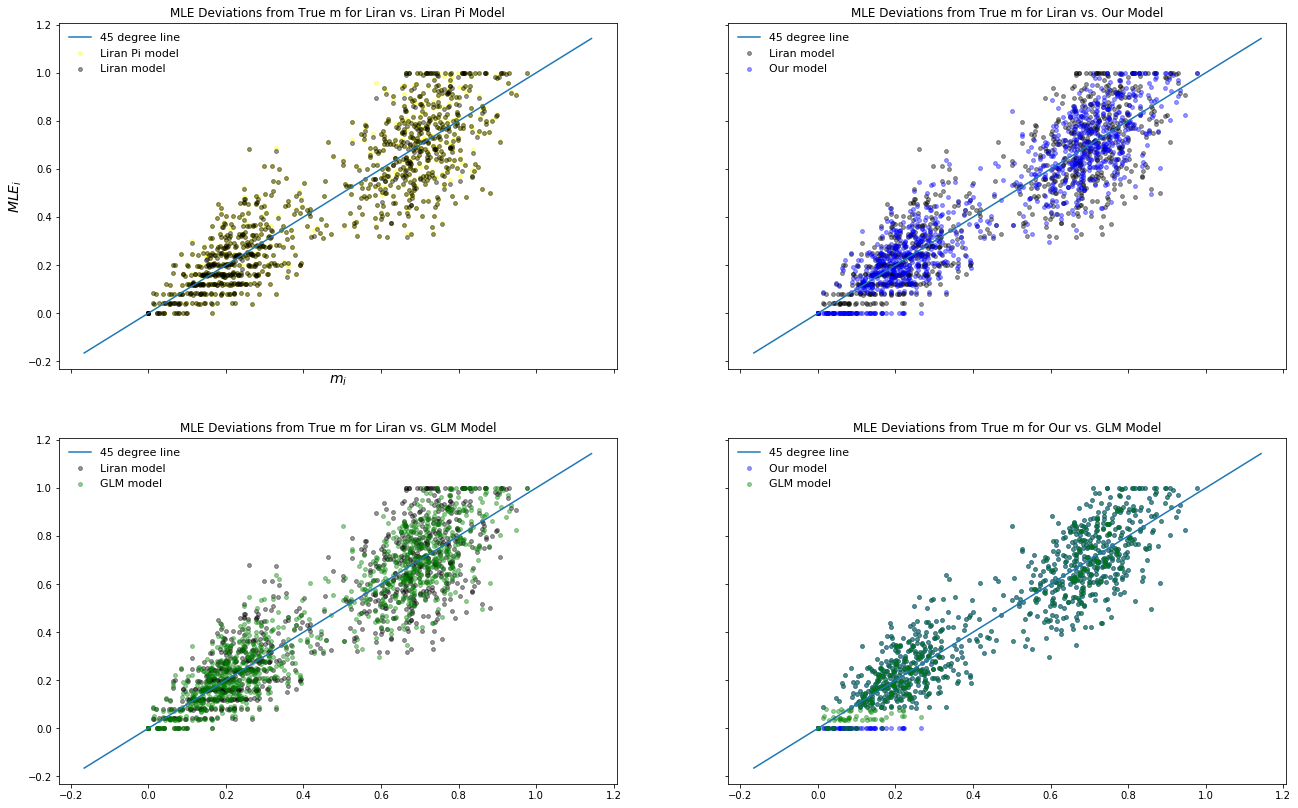

In [68]:
make_scatters(output['output_est'])


In [60]:
# Parameters:
# General:
###########################################
sample_len = 1000 # "DNA" sample length-> N
coverage_mean  = 200
coverage_sd = 5
#m_mean =  0.6
m_sd = 0.05
m_low = 0.2
m_high = 0.8
# Parameters for complex model:
m_initial_guess = 0.5 # for complex model
###########################################

# list objects for accounting:
t_list = []
est_simple_list = []
sd_simple_list = []
est_complex_list = []
sd_complex_list = []
pi_list = []
pi_mean_list = []
m_list = []
###########################################

# Simulating Data:
rng = range(0,sample_len) 
for i in rng:
    # Sampling m_i:
    #m = np.random.normal(m_mean, m_sd)
    m = random.sample([m_low,m_high],1)[0]
    m = np.random.normal(m,m_sd,1)
    #random.sample(np.random.normal(m_low, m_sd),np.random.normal(m_high, m_sd),)
    #
    if m>=1:
        m  = 0.9999
    elif m <=0:
        m = 0.0001
    #Sampling coverage:
    coverage = int(np.random.normal(coverage_mean, coverage_sd))
    # Sampling pi_i and pi_i_zero from a uniform dist:
    #pi = np.random.uniform(low=0.02, high=0.8, size=coverage)
#     pi_dist = 2*[0.8]+2*[0.4]+2*[0.2]+(coverage-6)*[0.02]
#     pi = np.array(random.choices(pi_dist,k=coverage))
    pi_dist = [0.4,0.3,0.2,0.1]
    weights = [5/50,5/50,5/50,35/50]
    pi = np.array(random.choices(pi_dist,weights=weights,k=coverage))
    theta = pi*m # Defining theta
    # Limiting theta:
    theta[theta>0.999]=0.9999
    theta[theta<0]=0.0001
    # Sampling t_i from a binomial(theta):
    t = np.random.binomial(1,theta)
    while sum(t==0)==len(t):
        t = np.random.binomial(1,theta)
    
    
    # Estimating using Liran's:
    pi_calib =  0.1597686029694
    solution_simple = t.sum()/(coverage*pi_calib) #MLE: m_i = t_i/(pi*n_i)
#     if solution_simple<0:
#         solution_simple=0
#     if solution_simple >1:
#         solution_simple = 1
    est_simple_list.append(solution_simple)
    sd_simple_list.append(np.sqrt(1/(-SOC_binom(t,pi_calib, solution_simple, coverage))))
    
    # Estimating m_i using complex model: 
    solution = fsolve(FOC, m_initial_guess,args=(coverage,pi,t))[0]
    #solution = sp.optimize.brentq(FOC,a = 0, b = 1 ,args=(coverage,pi,t))
    #solution = sp.optimize.root_scalar(FOC,args=(coverage,pi,t),bracket=[0,1], method='bisect').root
#     if solution<0:
#         solution=0
#     if solution >1:
#         solution = 1
    est_complex_list.append(solution)
    sd_complex_list.append(np.sqrt(1/(-SOC(solution,coverage,pi,t))))
    
    # Accounting:
    pi_list.append(pi)
    pi_mean_list.append(pi.mean())
    m_list.append(m[0])
    t_list.append(t)
    
output_df = pd.DataFrame(list(zip(m_list, pi_list ,t_list)), 
               columns =['samp_m', 'samp_p','samp_t'])
output_est = pd.DataFrame(list(zip(m_list,est_simple_list,est_complex_list)),columns =['true_m','liran','ours'])
#output_df.to_pickle('/Users/leecarlin/Dropbox (Personal)/School/deamination/simulation_MLE_35_coverage.pickle')

print('The empirical mean of m: {:,}'.format(np.array(m_list).mean()))
print('The empirical mean of pi: {:,}'.format(np.array(pi_mean_list).mean()))
print('The empirical mean of theta: {:,}'.format(np.array(pi_mean_list).mean()*np.array(m_list).mean()))

print('The mean of the simple model estimation: {:,}'.format(np.array(est_simple_list).mean()))
print('The mean of the complex model estimation: {:,}'.format(np.array(est_complex_list).mean()))
print('The std of the simple model estimation: {:,}'.format(np.array(est_simple_list).std()))
print('The std of the complex model estimation: {:,}'.format(np.array(est_complex_list).std()))
print('The mean of the simple model MLE STD: {:,}'.format(np.array(sd_simple_list).mean()))
print('The mean of the complex model STD: {:,}'.format(np.array(sd_complex_list).mean()))
MSE_liran = np.sqrt(((np.array(est_simple_list)-np.array(m_list))**2).mean())
MSE = np.sqrt(((np.array(est_complex_list)-np.array(m_list))**2).mean())
print('RMSE of Lirans Model: {:,}'.format(MSE_liran))
print('RMSE of Our Model: {:,}'.format(MSE))
print('RMSE DIfference: {:%}'.format((MSE-MSE_liran)/MSE_liran))
fltrd = output_est[output_est.ours>=0]
MSE_liran_fltrs = np.sqrt(((fltrd.liran-fltrd.true_m)**2).mean())
MSE_ours_fltrs = np.sqrt(((fltrd.ours-fltrd.true_m)**2).mean())
print('RMSE of Lirans Model: {:,}'.format(MSE_liran_fltrs))
print('RMSE of Our Model: {:,}'.format(MSE_ours_fltrs))
print('RMSE DIfference: {:%}'.format((MSE_ours_fltrs-MSE_liran_fltrs)/MSE_liran_fltrs))

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


The empirical mean of m: 0.48489083586608467
The empirical mean of pi: 0.15997730920348474
The empirical mean of theta: 0.0775715311792848
The mean of the simple model estimation: 0.4839384628837547
The mean of the complex model estimation: -2.038356168822863e+82
The std of the simple model estimation: 0.3189988935027004
The std of the complex model estimation: 1.029306957516975e+83
The mean of the simple model MLE STD: 0.028949260721864555
The mean of the complex model STD: 1.4437160286238015e+81
RMSE of Lirans Model: 0.11298311655226158
RMSE of Our Model: 1.0492958455567398e+83
RMSE DIfference: 92871915519464054360540022802641200505627324265109025507414392526001723187454237736960.000000%
RMSE of Lirans Model: 0.11337738268311544
RMSE of Our Model: 0.10778325281300921
RMSE DIfference: -4.934079%


RMSE of Lirans Model: 0.12422547937451367
RMSE of Our Model: 0.11960961644528699
RMSE DIfference: -3.715714%


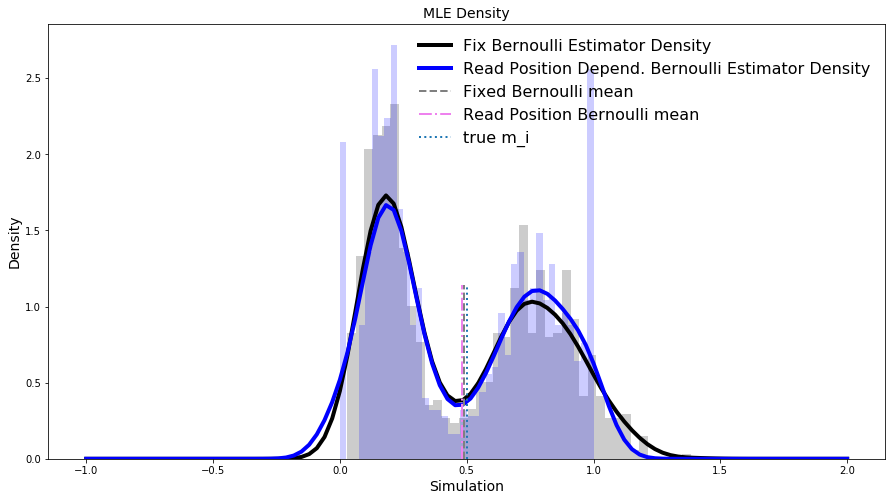

In [28]:
#Plot the distribution of our MLE and Lirans MLE 
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)

from scipy.stats import gaussian_kde
density_liran = gaussian_kde(est_simple_list)
density_our = gaussian_kde(est_complex_list)
xs = np.linspace(-1,2,100)
#density.covariance_factor = lambda : .25
#density._compute_covariance()
ax.plot(xs,density_liran(xs), color = 'black', label = 'Fix Bernoulli Estimator Density',lw=4)
ax.hist(est_simple_list, density=True, bins= 40, alpha = 0.2, color = 'black')
ax.plot(xs,density_our(xs), color = 'blue', label = 'Read Position Depend. Bernoulli Estimator Density',lw=4)
ax.hist(est_complex_list, density=True, bins= 40, alpha = 0.2, color = 'blue')

ax.axvline(np.array(est_simple_list).mean(),ymin=0, ymax= 0.4,linestyle = '--', label='Fixed Bernoulli mean', color = 'grey',lw=2)
ax.axvline(np.array(est_complex_list).mean(),ymin=0, ymax= 0.4 ,linestyle = '-.', label='Read Position Bernoulli mean', color = 'violet',lw=2)
ax.axvline((m_low+m_high)/2,ymin=0, ymax= 0.4 ,linestyle = ':', label='true m_i',lw=2)
ax.legend(fontsize = 16,frameon = False)
plt.xlabel('Simulation', fontsize=14)
plt.ylabel('Density', fontsize=14)
ax.set_title('MLE Density', fontsize=14)
#fig.savefig('/Users/leecarlin/Dropbox (Personal)/School/deamination/deamination_report_20200528/fig1.png',dpi=400)
plt.show()

In [22]:
# tmp = pd.DataFrame(list(zip(np.array(est_simple_list)-np.array(m_list), np.array(est_complex_list)-np.array(m_list))), 
#                columns =['fixed_est', 'our_est'])
# #tmp = tmp.sort_values('our_est', ascending=False)
# fig = plt.figure(figsize = (15,8))
# ax = fig.add_subplot(111)
# density_diff_fixed = gaussian_kde(tmp.fixed_est)
# density_diff_our = gaussian_kde(tmp.our_est)
# xs = np.linspace(-0.5,0.5,100)
# #density.covariance_factor = lambda : .25
# #density._compute_covariance()
# ax.plot(xs,density_diff_fixed(xs), color = 'black', label = 'Fix Bernoulli Estimator Error Density',lw=4, )
# ax.plot(xs,density_diff_our(xs), color = 'blue', label = 'Read Position Bernoulli Estimator Error Density',lw=4)

# ax.axvline(0 ,linestyle = '--', label='Zero Error', color = 'grey',lw=2)
# ax.set_title('Density comparison of MLE errors from True $m_i$ for Fixed vs. Read Position Model', fontsize=14)
# ax.legend()
# #fig.savefig('/Users/leecarlin/Dropbox (Personal)/School/deamination/deamination_report_20200528/fig2.png',dpi=400)
# plt.show()

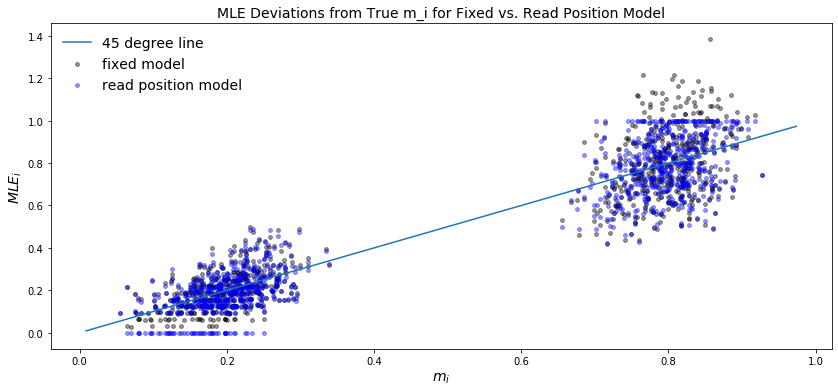

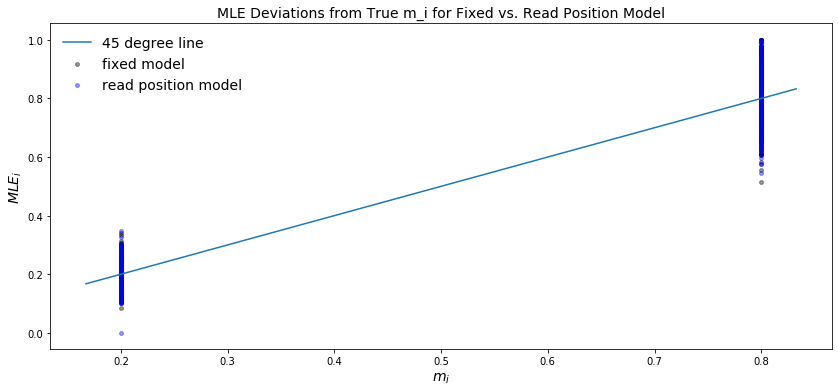

In [555]:
fig = plt.figure(figsize = (14,6))
ax = fig.add_subplot(111)
ax.scatter(m_list,est_simple_list, color='black', alpha = 0.4, label = 'fixed model', s=15 )
ax.scatter(m_list,est_complex_list, color='blue', alpha = 0.4, label = 'read position model', s=15)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, label = '45 degree line')
ax.set_title('MLE Deviations from True m_i for Fixed vs. Read Position Model', fontsize=14)
plt.xlabel('$m_i$', fontsize=14)
plt.ylabel('$MLE_i$', fontsize=14)
plt.legend(loc='upper left',frameon = False,fontsize= 14)
fig.savefig('/Users/leecarlin/Dropbox (Personal)/School/deamination/deamination_report_may_2020/fig3.png',dpi=400)
plt.show()